In [ ]:
# Version 2 is an expansion of features and then an expansion of data size.
# First the additional features were included. 3 of the features get normalized
# as NaN (Not a Number), so they are excluded from the models.
# Next the entirety of UAV4 Down is used in predictions. This contains roughly
# ~1.5 million time step points for a total of ~15 million datapoints.

# This will contain a lot of the charts we require for our Cycle 2 presentation.

# Adapted the weather time series tutorial by tensorflow to our traffic data.
# This code baby steps through tensorflows models.

# Table of Contents 
#   Import Data
#   Feature Engineering
#     Split/Train/Normalize
#     Data Windowing
#   Single Step Models (6)
#     Baseline, Linear, Dense, Multi-Step Dense, Convolution NN, Recurrent NN
#     Performance Comparison
#   Multi-Step Models (3)
#     Baseline, Single-Shot, AutoRegressive (Back Propagation)
#     Performance Comparison

In [ ]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from google.colab import drive

In [ ]:
# Mount Google Drive so we can access it
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# List files in our shared drive so we know what we need
!ls 'gdrive/Shareddrives/CPSC 4176 Project Spring 2023/UAV Data'

'Error evidence'	 'UAV 3 Information.txt'  'UAV 5.mp4'
'UAV 1 Data.xlsx'	 'UAV 3.mp4'		  'UAV 5 Road Layout.jpg'
'UAV 1 Information.txt'  'UAV 3 Road Layout.png'  'UAV 6 Data frenet.csv'
'UAV 1.mp4'		  UAV_4_Data_down.xlsx	  'UAV 6 Data pixel.csv'
'UAV 1 Road Layout.png'   UAV_4_Data_up.xlsx	  'UAV 6 Information.txt'
'UAV 2 Data.xlsx'	 'UAV 4 Information.txt'  'UAV 6.mp4'
'UAV 2 Information.txt'  'UAV 4.mp4'		  'UAV 6 Road Layout.png'
'UAV 2.mp4'		 'UAV 4 Road Layout.jpg'  'UAV 6 timespace data.jpg'
'UAV 2 Road Layout.png'  'UAV 5 Data.xlsx'
'UAV 3 Data.xlsx'	 'UAV 5 Information.txt'


In [ ]:
# Read data into pandas dataframe
# Extracts all 5 lanes "sheets" into a dictionary of dataframes
# This takes ~5 minutes and still only consists of one direction of UAV4 highway
url = "gdrive/Shareddrives/CPSC 4176 Project Spring 2023/UAV Data/UAV_4_Data_down.xlsx"
uav4_dict_df = pd.read_excel(url, sheet_name=["Sheet1", "sheet2", "sheet3", "sheet4", "sheet5"])
# display shape
#data.shape

NameError: ignored

In [ ]:
# Feature Engineering

In [ ]:
# Counts and displays how many datapoints per vehicle (in lane 1 only)
# I use this specifically to grab a vehicle to test

# OLD
#vehicle_datapoints = {}
#for vehicle in data['VehicleID']:
#  vehicle_datapoints[vehicle] = vehicle_datapoints.get(vehicle, 0) + 1
#vehicle_datapoints

In [ ]:
# Similar to above, counts the datapoints per vehicle, but through all lanes
# This helped me find a vehicle who performed a lane changed.
#vehicle_datapoints = {}
#for lane in uav4_dict_df:
#  for vehicle in uav4_dict_df[lane]['VehicleID']:
#    vehicle_datapoints[vehicle] = vehicle_datapoints.get(vehicle, 0) + 1

#print("VehicleID:", max(vehicle_datapoints, key=vehicle_datapoints.get),
#      "Value:", max(vehicle_datapoints.values()))

In [ ]:
# Searches for specific VehicleID and extracts all data for that vehicle
# This will work through all lanes
#search_vehicle_id = 8191
#vehicle_data = pd.DataFrame()
#for lane in uav4_dict_df:
  #vehicle_data = pd.concat([vehicle_data, uav4_dict_df[lane].loc[uav4_dict_df[lane]['VehicleID'] == search_vehicle_id]])
#vehicle_data

In [ ]:
# all lanes
vehicle_data = pd.concat([uav4_dict_df['Sheet1'], uav4_dict_df['sheet2']])
vehicle_data = pd.concat([vehicle_data, uav4_dict_df['sheet3']])
vehicle_data = pd.concat([vehicle_data, uav4_dict_df['sheet4']])
vehicle_data = pd.concat([vehicle_data, uav4_dict_df['sheet5']])
vehicle_data

,VehicleID,LaneID,Time(s),x-axis position(m),Distance from upper Lane line(m),Distance from lower lane line(m),Speed(m/s),Acceleration(m/s^2),VehicleLength(meter),VehicleWidth(meter)
0,7,1,0.03333,292.885000,1.516244,2.058017,17.160722,0.147550,5.101913,2.058609
1,7,1,0.06666,293.456967,1.523727,2.049199,17.165635,0.141271,5.101913,2.058609
2,7,1,0.09999,294.029097,1.531513,2.040078,17.170339,0.186334,5.101913,2.058609
3,7,1,0.13332,294.601385,1.539330,2.030925,17.176544,0.203683,5.101913,2.058609
4,7,1,0.16665,295.173879,1.547176,2.021743,17.183327,0.195536,5.101913,2.058609
...,...,...,...,...,...,...,...,...,...,...
9324,14636,5,1166.21670,304.726754,0.073932,3.202921,17.014972,0.264952,4.608019,2.160101
9325,14636,5,1166.25003,305.293863,0.059896,3.212419,17.023795,0.271473,4.608019,2.160101
9326,14636,5,1166.28336,305.861266,0.045632,3.222144,17.032835,0.264751,4.608019,2.160101
9327,14636,5,1166.31669,306.428971,0.031139,3.232095,17.041652,0.286796,4.608019,2.160101


In [ ]:
# Plots individual vehicle speed, acceleration, lane position
#vehicle_data.plot(kind='line', x='Time(s)', y='Speed(m/s)', color='blue', title="Vehicle: " + str(search_vehicle_id))
#vehicle_data.plot(kind='line', x='Time(s)', y='Acceleration(m/s^2)', color='blue', title="Vehicle: " + str(search_vehicle_id))
#vehicle_data.plot(kind='line', x='Time(s)', y='Distance from upper Lane line(m)', color='blue', title="Vehicle: " + str(search_vehicle_id))
#vehicle_data.plot(kind='line', x='Time(s)', y='Distance from lower lane line(m)', color='blue', title="Vehicle: " + str(search_vehicle_id))
# These graphs are much better to display our features

In [ ]:
# TODO: Update to H&D's normalized data

# We need to normalize the data between 0 and 1
# data' is normalized between 0 and 1
# data' = (data - data_min) / (data_max - data_min)

def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

#normalized_data = pd.DataFrame()
# normalized_data['Time'] = vehicle_data['Time(s)']
#normalized_data['Speed'] = NormalizeData(vehicle_speed['Speed(m/s)'])
# normalized_data['Acceleration'] = NormalizeData(vehicle_data['Acceleration(m/s^2)'])

#normalized_data

In [ ]:
vehicle_data = vehicle_data.drop(['VehicleID', 'VehicleLength(meter)', 'VehicleWidth(meter)'], axis=1)
vehicle_data = NormalizeData(vehicle_data)
vehicle_data.rename(columns={'Speed(m/s)':'Speed'}, inplace=True)
vehicle_data

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


,LaneID,Time(s),x-axis position(m),Distance from upper Lane line(m),Distance from lower lane line(m),Speed,Acceleration(m/s^2)
0,0.0,0.000000,0.817033,0.328920,0.446335,0.626605,0.378091
1,0.0,0.000028,0.818644,0.330543,0.444423,0.626811,0.378074
2,0.0,0.000056,0.820256,0.332232,0.442444,0.627008,0.378197
3,0.0,0.000084,0.821868,0.333928,0.440459,0.627267,0.378244
4,0.0,0.000113,0.823481,0.335630,0.438468,0.627551,0.378222
...,...,...,...,...,...,...,...
9324,1.0,0.984386,0.850391,0.016037,0.694639,0.620505,0.378412
9325,1.0,0.984414,0.851989,0.012992,0.696699,0.620875,0.378430
9326,1.0,0.984442,0.853587,0.009897,0.698808,0.621253,0.378412
9327,1.0,0.984470,0.855186,0.006753,0.700966,0.621622,0.378472


In [ ]:
# TODO: Split and train better, P got scikit to work

# I believe this method takes the first 70% as training
# instead of grabbing 70% randomly from the list which would be better, correct?

# Split data into training, validation, and test sets
column_indices = {name: i for i, name in enumerate(vehicle_data.columns)}

n = len(vehicle_data)
train_df = vehicle_data[0:int(n*0.7)]
val_df = vehicle_data[int(n*0.7):int(n*0.9)]
test_df = vehicle_data[int(n*0.9):]

num_features = vehicle_data.shape[1]

In [ ]:
#train_mean = train_df.mean()
#train_std = train_df.std()

#train_df = (train_df - train_mean) / train_std
#val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

In [ ]:
# TODO: Update to H&D's normalized data
# TODO: Add to above

# Display min/max normalization
# Confirms normalization
#print("Max Speed: ", vehicle_data['Speed(m/s)'].max(), "Min Speed: ", vehicle_data['Speed(m/s)'].min())
## print("Max Accel: ", vehicle_data['Acceleration(m/s^2)'].max(),"Min Accel: ",  vehicle_data['Acceleration(m/s^2)'].min())
#print("Max Speed: ", normalized_data['Speed'].max(), "Min Speed: ", normalized_data['Speed'].min())
# print("Max Accel: ", normalized_data['Acceleration'].max(),"Min Accel: ",  normalized_data['Acceleration'].min())
#normalized_data

In [ ]:
# TODO: Adapt this to our min/max? This is from the TensorFlow's tutorial

# Check distribution of features in order to confirm there are no obvious
# erroneous errors like -9999 before hand

#df_std = (vehicle_data - train_mean) / train_std
#df_std = df_std.melt(var_name='Column', value_name='Normalized')
#plt.figure(figsize=(12, 6))
#ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(vehicle_data.keys(), rotation=90)

In [ ]:
# Data Windowing
# Our goal is to make a set of predictions based on a window of
# consecutive samples from the data
#   -width (num of time steps) of input and label windows
#   -time offset between them
#   -which features are used as inputs, labels, or both
# Example: to predict 24 hours into the future with 24 hours of data
#   input width = 24, offset = 24 (label width = 1), total width 48
# Example: predict 1 hour into future given 6 hours of data
#   input width = 6, offset = 1 (label width = 1), total width = 7


# TODO: Is there a better way to handle the time steps?

# Our data is in time increments of 0.0333 seconds instead of 1 hour
# Number of time data points to how much actual time
# 750 = ~25 seconds
# 1800 = ~60 seconds
# 9000 = ~5 minutes
# 36000 = ~20 minutes

In [ ]:
# Window Generator
# Creates the windowing described above
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [ ]:
# Converts a list of consecutive inputs to a window of inputs and labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Plot allows for simple visulization of the split window
def plot(self, model=None, plot_col='Speed', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [0.0333 seconds]')

WindowGenerator.plot = plot

In [ ]:
# TODO: Can I do this from the start?

# Takes a time series pd.dataframe and converts to a tf.data.Dataset
# of (input_window, label_window) pairs
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
# WindowGenerator holds training, validation, and test data
# Add properties for accessing them as tf.data.Dataset
# Add standard example batch for easy access and plotting
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# These next models have single-output and multi-output predictions,
# and single-time-step and multi-time-step predictions

# Single step models
# The simplest model you can build on this sort of data is one that predicts 
# a single feature's value, 1 time step (0.0333 seconds) into the future based 
# only on the current conditions.

# generate a single-step pair (input, label)
# Makes 1 time step predictions, given 1 time step of history
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['Speed'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Speed']

In [ ]:
# window object creates training, validation, and test sets
# can iterate over batches of data
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
# We should establish a performance baseline as a point for comparison with
# the later more complicated models

# Baseline, predicts one time step into the future (0.0333 seconds)
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
# instantiate and evaluate model
baseline = Baseline(label_index=column_indices['Speed'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline SS'] = baseline.evaluate(single_step_window.val)
performance['Baseline SS'] = baseline.evaluate(single_step_window.test, verbose=0)

9324/9324 [==============================] - 41s 4ms/step - loss: 4.9911e-05 - mean_absolute_error: 7.2905e-04


In [ ]:
# Single Step isn't helpful, so we need to widen the time
# Create wider window for 50 time steps instead of 1
# Vehicle 13909 has 808 datapoints in Lane 1
# 70% (training size) of that is 565 (scale to index, so 564) 

# This errors out in a few different models if it's larger than 50
# I believe this is due to the data size being too small
# Some models work with 100, 200, 500, but others will break

# TODO: Test on larger data 

# This generates 50 time steps of consecutive inputs and labels at a time
# This doesn't change the way the model operates.
# Still makes 1 time step predictions, given 1 time step of history
# each prediction is made independently
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1, label_columns=['Speed'])

wide_window

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label column name(s): ['Speed']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 50, 7)
Output shape: (32, 50, 1)


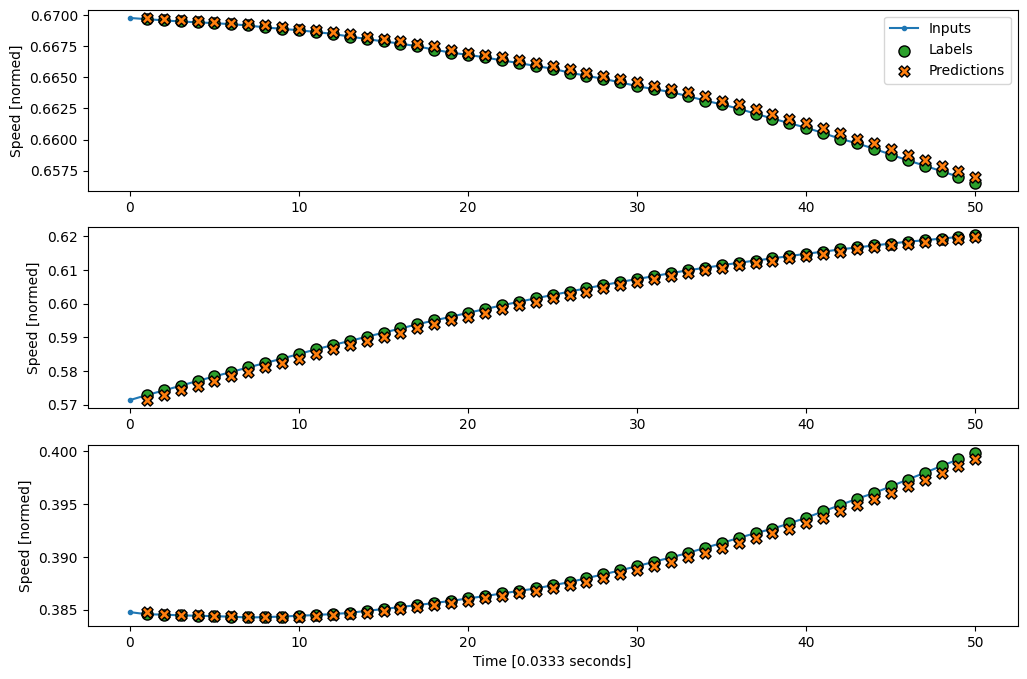

In [ ]:
# Blue inputs line shows input temp at each time step
# Green labels dot show target prediction value
# Orange prediction crosses show predicted value at each time step-+
wide_window.plot(baseline)

In [ ]:
# Creates a compile and fit method because we're using many models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
# Linear model
# Simplest trainable model
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)
# Shape: (batch, time, inputs)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


In [ ]:
# Train and evaluate
history = compile_and_fit(linear, single_step_window)

val_performance['Linear SS'] = linear.evaluate(single_step_window.val)
performance['Linear SS'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
32634/32634 [==============================] - 193s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0163 - val_loss: 4.7757e-05 - val_mean_absolute_error: 6.7062e-04
Epoch 2/20
32634/32634 [==============================] - 194s 6ms/step - loss: 4.5075e-05 - mean_absolute_error: 0.0013 - val_loss: 4.7647e-05 - val_mean_absolute_error: 7.2785e-04
Epoch 3/20
32634/32634 [==============================] - 192s 6ms/step - loss: 4.5079e-05 - mean_absolute_error: 0.0013 - val_loss: 4.8121e-05 - val_mean_absolute_error: 9.5355e-04
Epoch 4/20
32634/32634 [==============================] - 185s 6ms/step - loss: 4.5032e-05 - mean_absolute_error: 0.0012 - val_loss: 4.7565e-05 - val_mean_absolute_error: 6.5029e-04
Epoch 5/20
32634/32634 [==============================] - 187s 6ms/step - loss: 4.5080e-05 - mean_absolute_error: 0.0013 - val_loss: 5.0641e-05 - val_mean_absolute_error: 0.0019
Epoch 6/20
9324/9324 [==============================] - 45s 5ms/step - loss: 5.0593e-05 - mean_abs

Input shape: (32, 50, 7)
Output shape: (32, 50, 1)


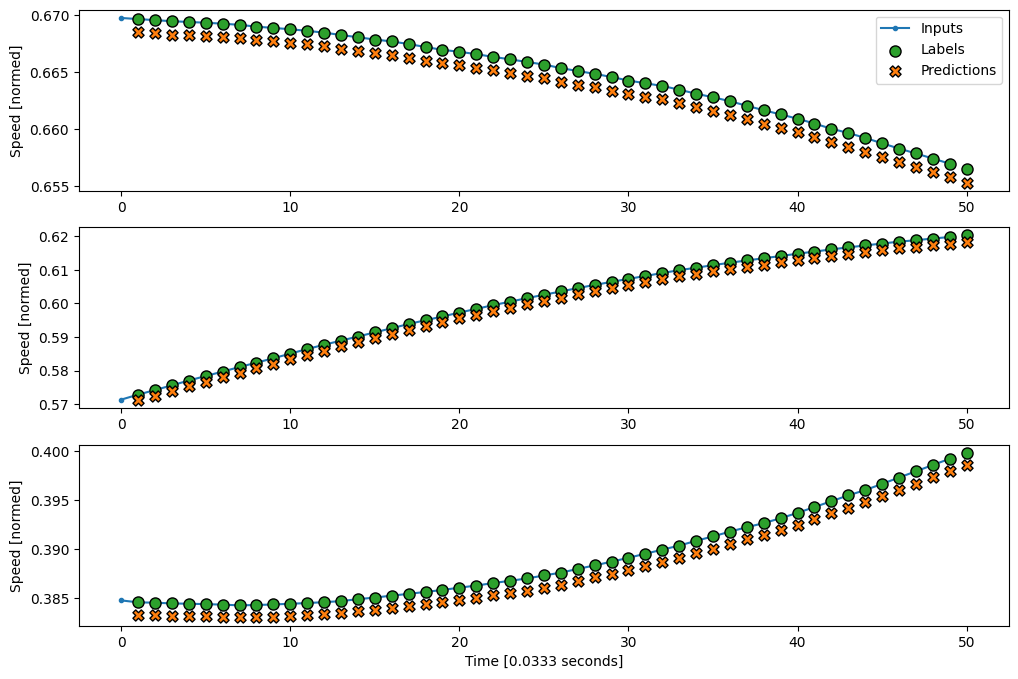

In [ ]:
# Plot linear model
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)

# NOTE: Linear is almost identical but is backwards
#         If the current sign is flipped, I think it would accurate
# TODO: Why?

In [ ]:
# IGNORE THIS, Only dealing with Speed currently, this will matter with more

# It's possible to examine the layers weights
# Random initialization doesn't always place most weight on temperature, main flaw of this

#plt.bar(x = range(len(train_df.columns)),
#        height=linear.layers[0].kernel[:,0].numpy())
#axis = plt.gca()
#axis.set_xticks(range(len(train_df.columns)))
#_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
# dense single step model
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense SS'] = dense.evaluate(single_step_window.val)
performance['Dense SS'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
32634/32634 [==============================] - 208s 6ms/step - loss: 1.3660e-04 - mean_absolute_error: 0.0036 - val_loss: 4.9011e-05 - val_mean_absolute_error: 9.8479e-04
Epoch 2/20
32634/32634 [==============================] - 231s 7ms/step - loss: 5.2050e-05 - mean_absolute_error: 0.0023 - val_loss: 4.8546e-05 - val_mean_absolute_error: 7.9702e-04
Epoch 3/20
32634/32634 [==============================] - 226s 7ms/step - loss: 5.0029e-05 - mean_absolute_error: 0.0021 - val_loss: 5.0616e-05 - val_mean_absolute_error: 0.0018
Epoch 4/20
9324/9324 [==============================] - 45s 5ms/step - loss: 4.8718e-05 - mean_absolute_error: 0.0011


Input shape: (32, 50, 7)
Output shape: (32, 50, 1)


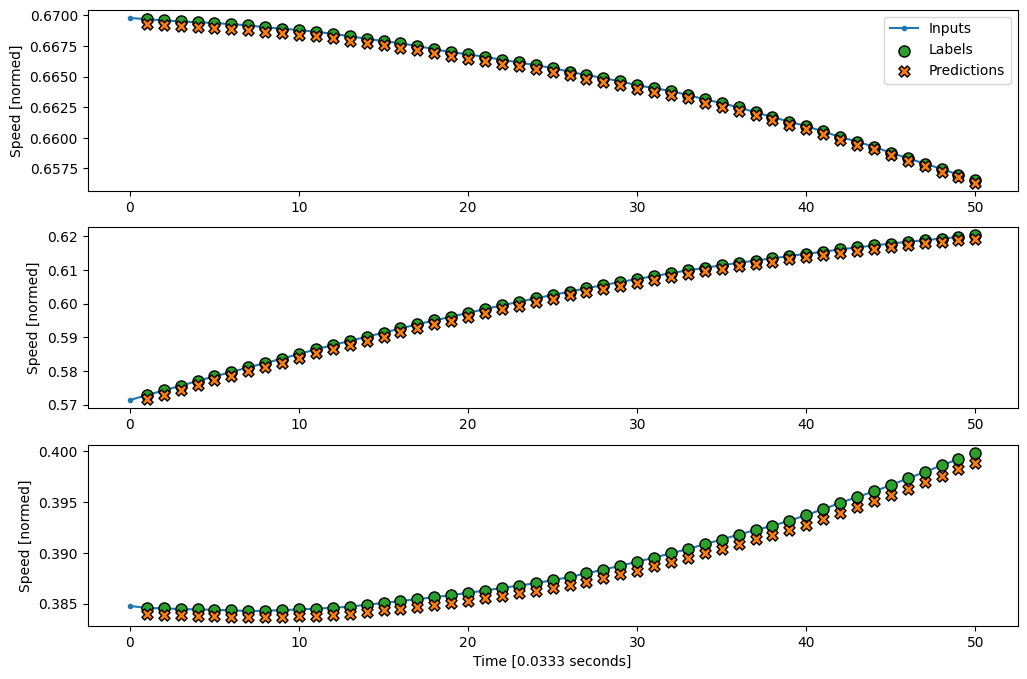

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(dense)

In [ ]:
# Baseline, linear, dense models handle each time step independently
# Multi-step models will take multiple time steps as input to produce a single output

# Multi-Step Dense Model
# Creates batches of 50 time step inputs and 1 time step label (old = 3)
CONV_WIDTH = 50
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Speed'])

conv_window

# error: cannot convert infinity float to integer on conv_width 200+
# This is due to SMALL data sizes

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50]
Label column name(s): ['Speed']

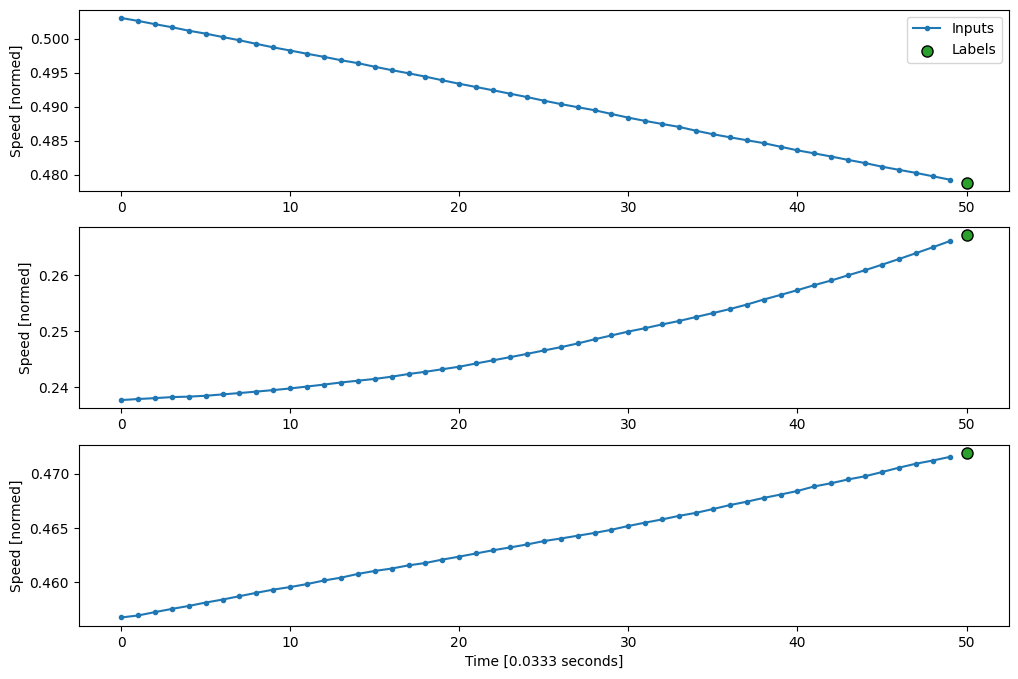

In [ ]:
conv_window.plot()

In [ ]:
# Train dense model on multi-input-step window by flattening first
# Down-side: model can only be executed on input windows of exactly this shape
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 50, 7)
Output shape: (32, 1, 1)


In [ ]:
# Train and evaluate dense multi-step model
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi Step Dense CW'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi Step Dense CW'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

9323/9323 [==============================] - 46s 5ms/step - loss: 7.0111e-05 - mean_absolute_error: 0.0038


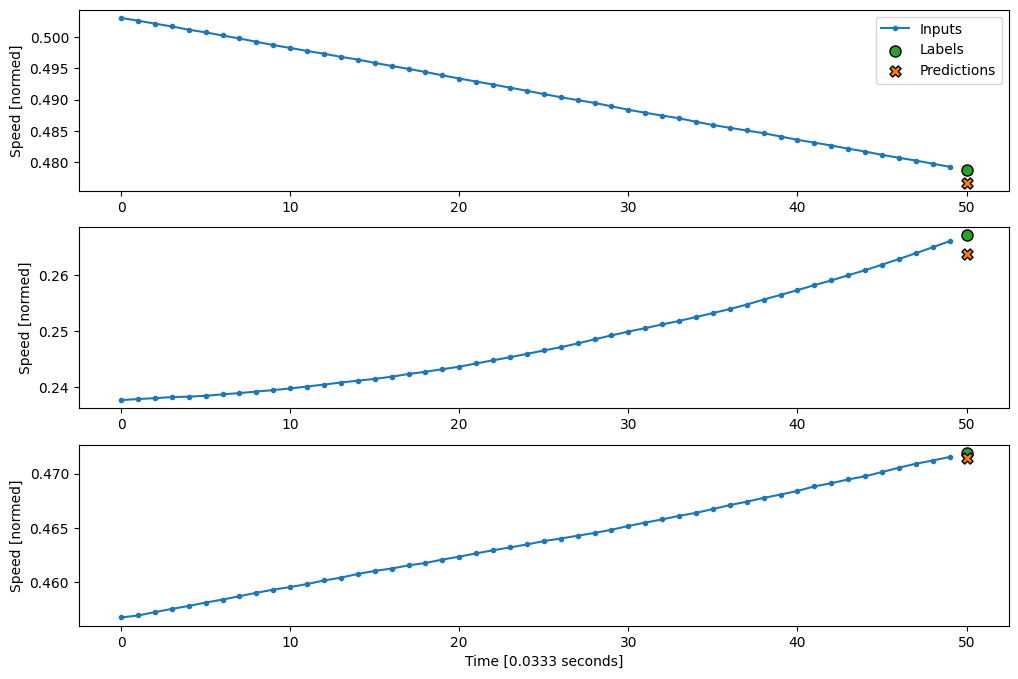

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
# Convolution Neural Network
# Exact same as the dense model except
# Flatten and first dense are replaced by Conv1D
# Reshape is no longer necessary since convolution keeps time axis in output
# Conv_models can be run on inputs of any length, multi-step dense cannot
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 50, 7)
Output shape: (32, 1, 1)


In [ ]:
# Train and evaluate
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv CW'] = conv_model.evaluate(conv_window.val)
performance['Conv CW'] = conv_model.evaluate(conv_window.test, verbose=0)

9323/9323 [==============================] - 46s 5ms/step - loss: 1.0297e-04 - mean_absolute_error: 0.0064


In [ ]:
# If given a wider input, you will receive a wider output
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 50, 7)
Labels shape: (32, 50, 1)
Output shape: (32, 1, 1)


In [ ]:
# Output is shorter than input
# to train/plot, we need labels and prediction to have same length
# WindowGenerator produces wide windows with extra input time steps so
# the label/prediction lengths match

# Makes 50 time step predictions, given 99 (100 - 1) time step of history
LABEL_WIDTH = 50
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Speed'])

wide_conv_window

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): ['Speed']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 99, 7)
Labels shape: (32, 50, 1)
Output shape: (32, 50, 1)


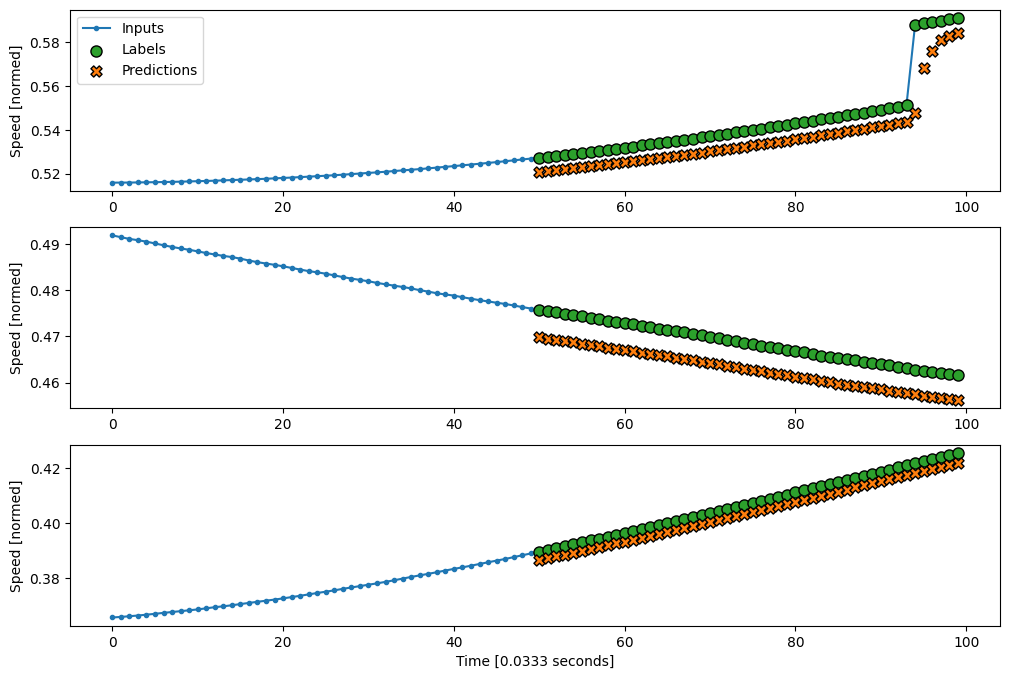

In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
# recurrent neural network
# well suited for time series data, process a time series step-by-step
# maintaining an internal state from time-step to time-step
# return_sequence = false, default, layer only returns output of final time step
# giving model time to warm up internal state before making single prediction
# return_sequence = true, layer returns outfor for each input
# useful for stacking RNN layers, training model on multiple time steps simultaneously

In [ ]:
# long short term memory model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)])
# return_sequences = true, model can be trained on 24 hours of data at a time

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 50, 7)
Output shape: (32, 50, 1)


In [ ]:
# train and evaluate
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM WW'] = lstm_model.evaluate(wide_window.val)
performance['LSTM WW'] = lstm_model.evaluate(wide_window.test, verbose=0)

9323/9323 [==============================] - 110s 12ms/step - loss: 4.8337e-05 - mean_absolute_error: 8.9991e-04


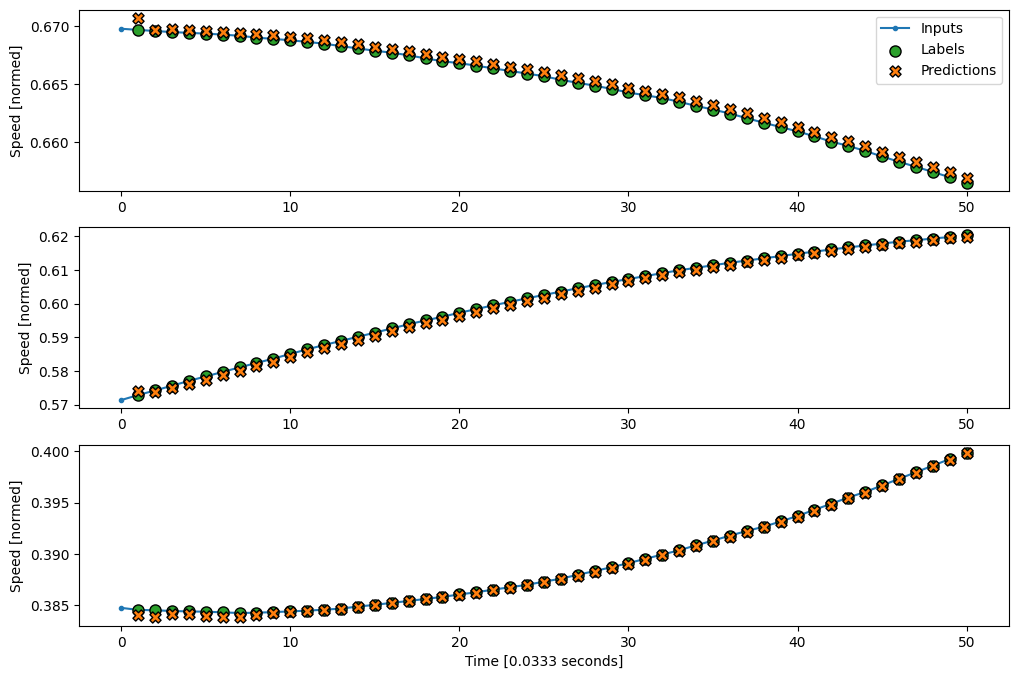

In [ ]:
wide_window.plot(lstm_model)

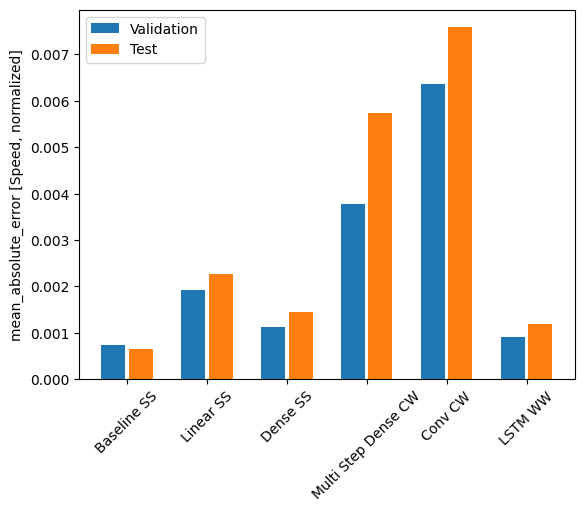

In [ ]:
# performance comparison of each model
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Speed, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline SS : 0.0006
Linear SS   : 0.0023
Dense SS    : 0.0015
Multi Step Dense CW: 0.0057
Conv CW     : 0.0076
LSTM WW     : 0.0012


In [ ]:
# multi-output models
# previous models only focused on a single output feature
# all models can be converted to predict multiple features by changing
# the number of units in the output layer and adjusting the training windows
# to include all features in the labels

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1)
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.

wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 50, 7)
Labels shape (batch, time, features): (32, 50, 7)


In [ ]:
# baseline
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline WW'] = baseline.evaluate(wide_window.val)
performance['Baseline WW'] = baseline.evaluate(wide_window.test, verbose=0)

9323/9323 [==============================] - 40s 4ms/step - loss: 3.2554e-04 - mean_absolute_error: 0.0013


In [ ]:
# dense
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense SS'] = dense.evaluate(single_step_window.val)
performance['Dense SS'] = dense.evaluate(single_step_window.test, verbose=0)

9324/9324 [==============================] - 40s 4ms/step - loss: 4.6216e-04 - mean_absolute_error: 0.0077


In [ ]:
# recurrent neural network
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM WW'] = lstm_model.evaluate(wide_window.val)
performance['LSTM WW'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
# residual connections
# models were initialized randomly and then had to learn
# it's easier to build this into the model structure
# it's common in time series to predict how the value will change instead of
# predicting the next value
# we want to initialize models to match baseline, which helps models converge
# faster and improve performance. this can be used with ANY model

In [ ]:
# residual connection applied to LSTM model
# ensures initial predictions are small and don't overpower the connection
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM WW'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM WW'] = residual_lstm.evaluate(wide_window.test, verbose=0)

9324/9324 [==============================] - 79s 8ms/step - loss: 3.2230e-04 - mean_absolute_error: 0.0022
CPU times: user 1h 40min 56s, sys: 6min 29s, total: 1h 47min 26s
Wall time: 1h 20min 35s


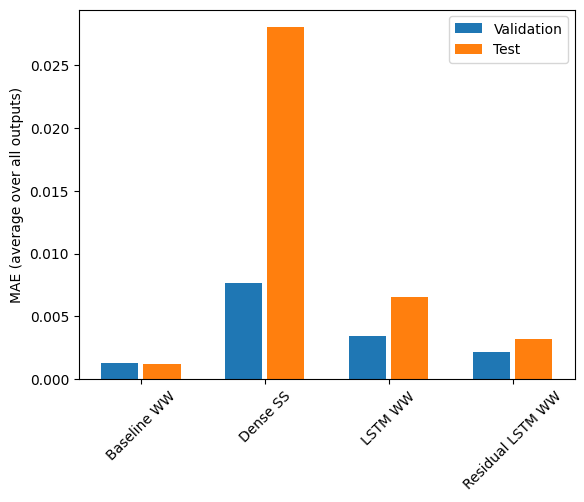

In [ ]:
# performance of multi-output models
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline WW    : 0.0012
Dense SS       : 0.0280
LSTM WW        : 0.0066
Residual LSTM WW: 0.0032


Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

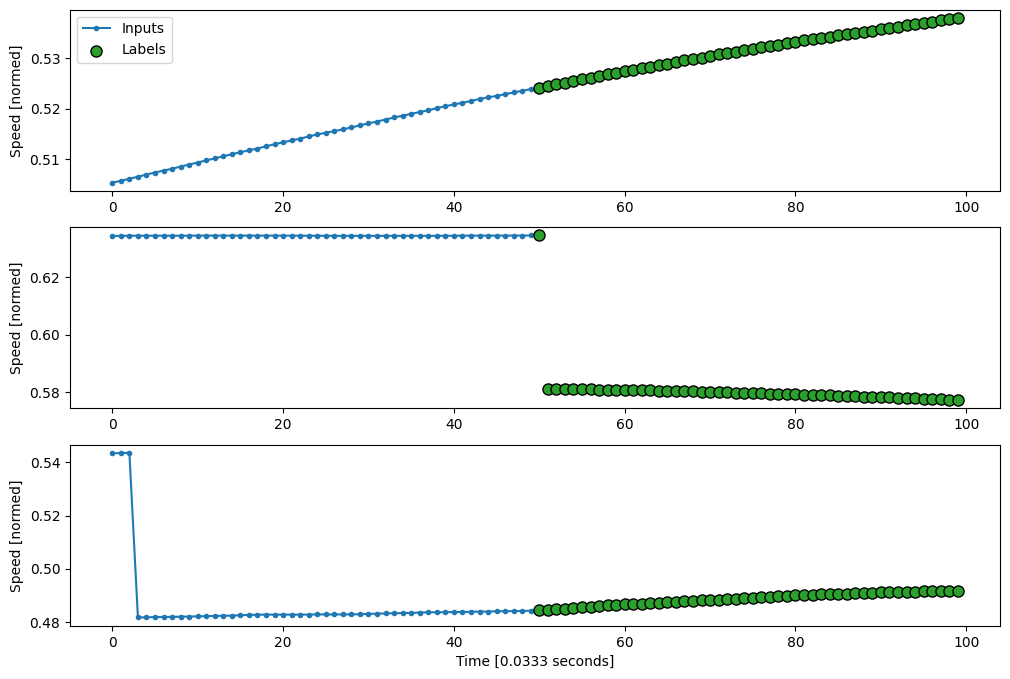

In [ ]:
# Multi-Step Models
# These models will make multiple time step predictions instead of 1 time step
# Two Approaches, 
#   Single shot, predicts entire time series at once
#   Autoregressive, predicts single step, output fed back as input
# These models predict all features across all output time steps

# Makes 50 time step predictions, given 50 time step of history
OUT_STEPS = 50
multi_window = WindowGenerator(
    input_width=50, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

9321/9321 [==============================] - 40s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0282


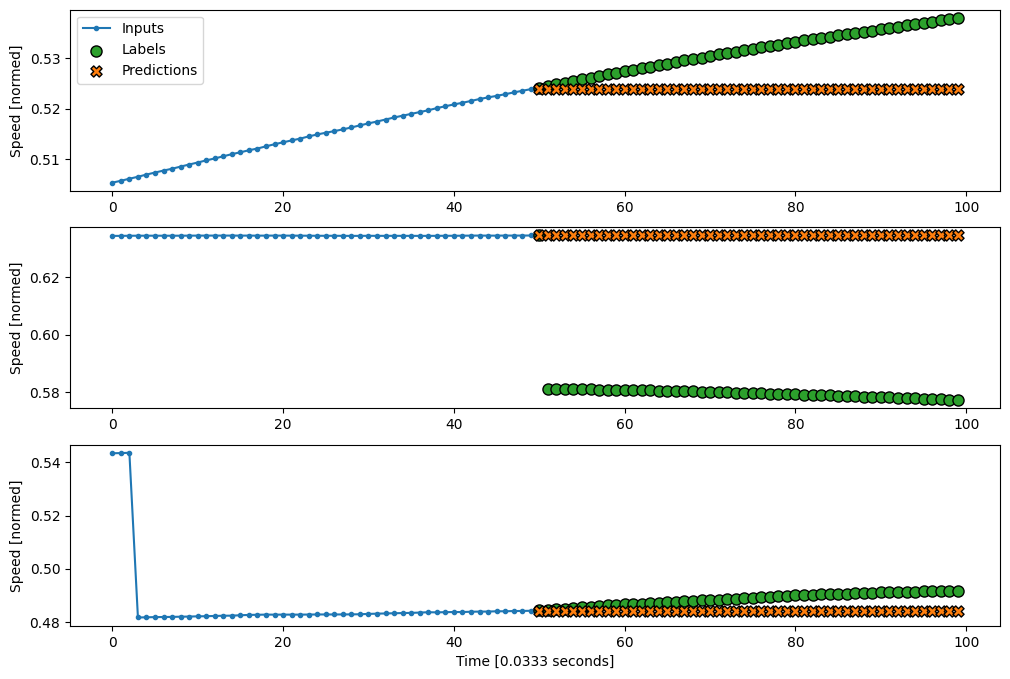

In [ ]:
# baseline
# repeats last input time step for required number of output time steps
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last Baseline MW'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last Baseline MW'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

9321/9321 [==============================] - 38s 4ms/step - loss: 0.0157 - mean_absolute_error: 0.0515


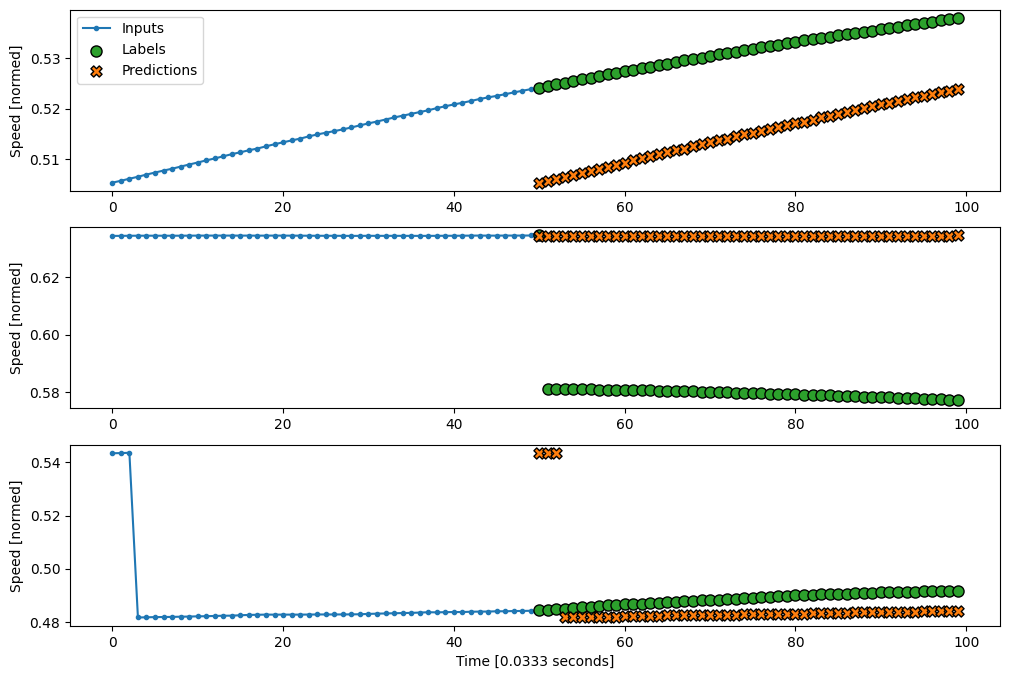

In [ ]:
# repeats the previous day, assuming tomorrow will be similar
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat Baseline MW'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat Baseline MW'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

9321/9321 [==============================] - 42s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0294


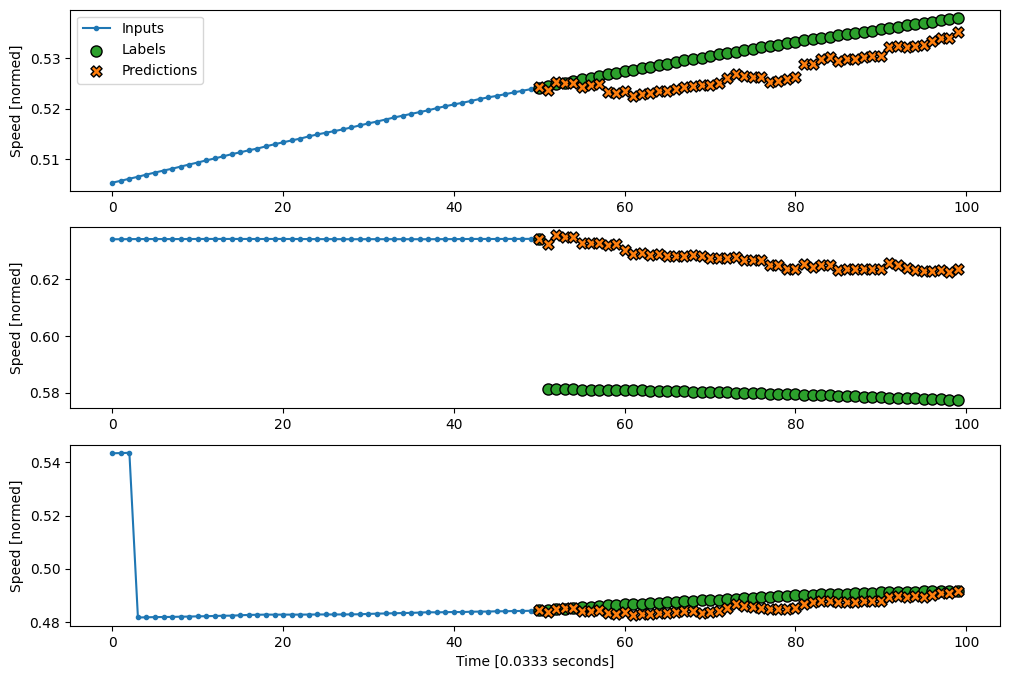

In [ ]:
# Single Shot Models
# Makes entire sequence prediction in single step
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Single Shot Multi Linear MW'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Single Shot Multi Linear MW'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

9321/9321 [==============================] - 49s 5ms/step - loss: 0.0109 - mean_absolute_error: 0.0446


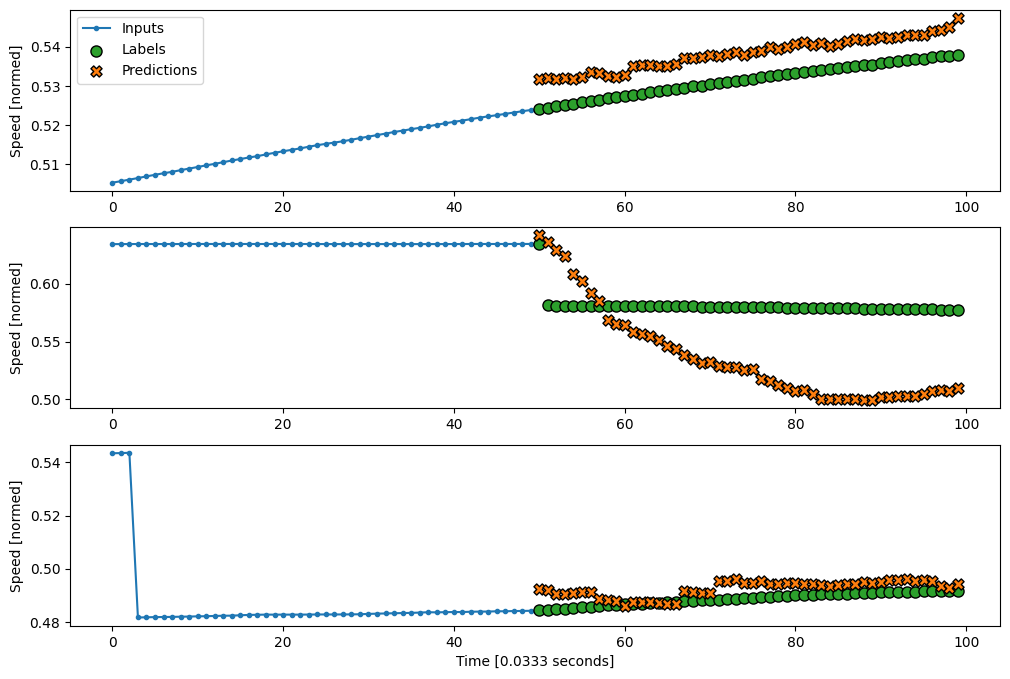

In [ ]:
# Adding dense layer between input and output gives model more power
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Single Shot Multi Dense MW'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Single Shot Multi Dense MW'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

9321/9321 [==============================] - 45s 5ms/step - loss: 0.0074 - mean_absolute_error: 0.0362


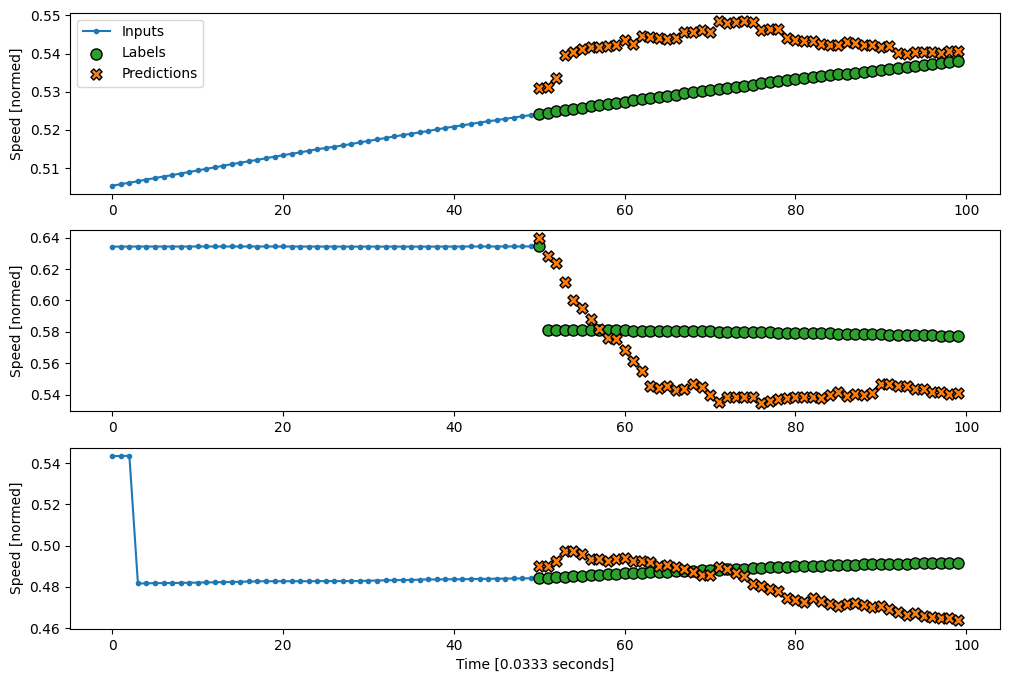

In [ ]:
# Convolutional Neural Network
# Makes predictions based on fixed width history, may lead to better performance
# than dense model since it can see how things change over time

# I've tried widths of 3 to 25, don't see much of a difference
CONV_WIDTH = 25 
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['CNN MW'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN MW'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

9321/9321 [==============================] - 104s 11ms/step - loss: 0.0043 - mean_absolute_error: 0.0215


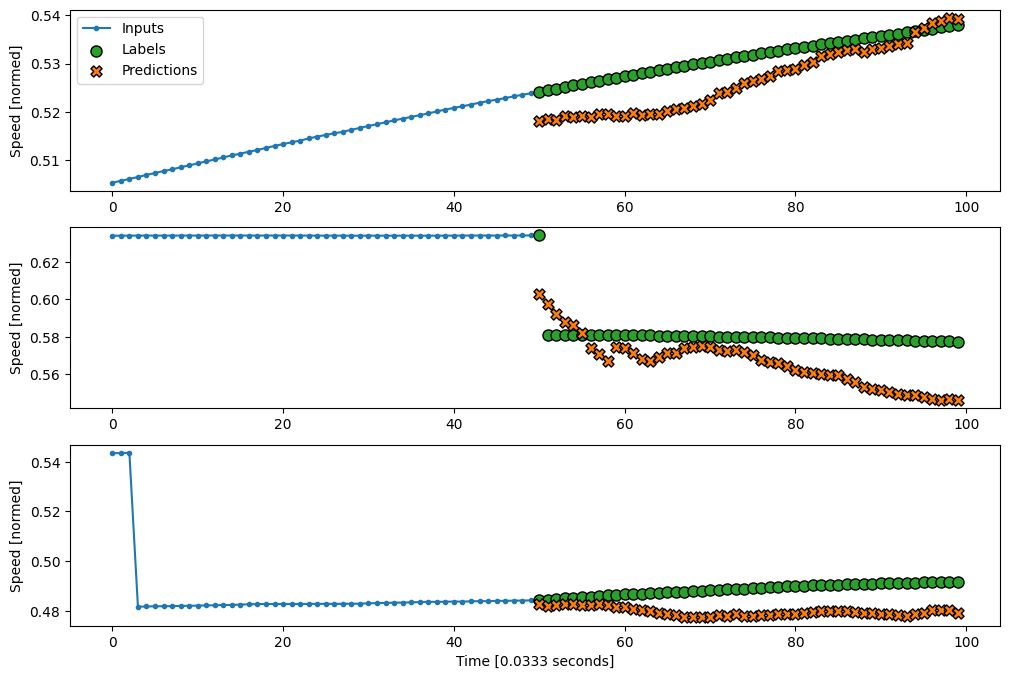

In [ ]:
# Recurrent Neural Network
# Learns to use long history of inputs if relevant to predictions
# Accumulates 50 time steps before making a single prediction for 50 time steps
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM MW'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM MW'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
# Autoregressive Model
# Decomposes prediction into individual time steps, feeds output back into 
# itself at each step and prediction can be conditioned to the previous one
# Any single step multi-output model can be fed into an Autoregreesive loop
# Recurrent Neural Network is explicitly trained to do this though

# Model must manage inputs for each step
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
# Model requires a "warmup" to initialize internal state based on inputs
# equivalent to Single Step LSTM model from above
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
# Returns single time step prediction and internal state of LSTM
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 7])

In [ ]:
# Iterates the model feeding the predictions at each step back as input
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 50, 7)


9321/9321 [==============================] - 147s 16ms/step - loss: 0.0043 - mean_absolute_error: 0.0257


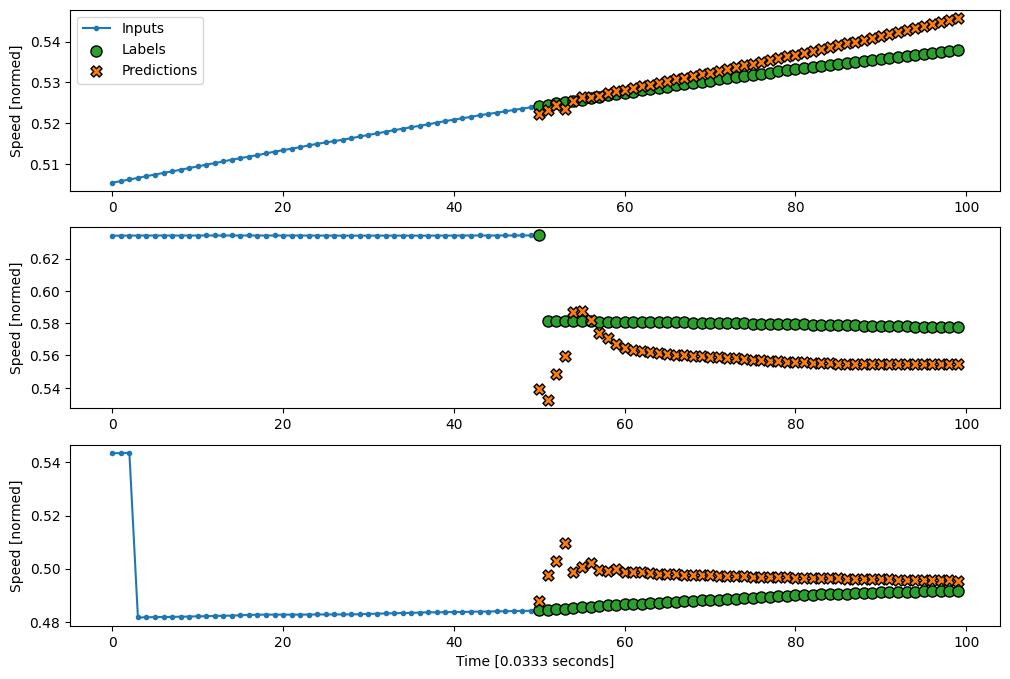

In [ ]:
# train and evaluate
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM MW'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM MW'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

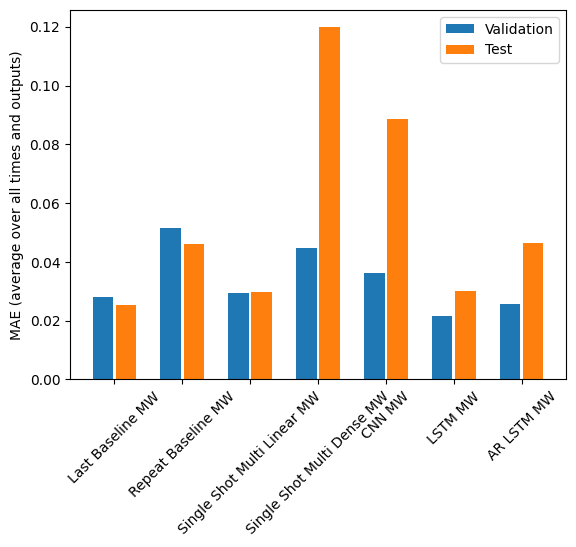

In [ ]:
# display performance
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]
# Error: There's no values in multi_performance, idk why
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
# there's no way of knowing which model performs best on the data until tried
# Example: backpropagation (AR LSTM) and Linear both perform poorly
# There's a chance this is due to my SMALL data size
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last Baseline MW: 0.0255
Repeat Baseline MW: 0.0462
Single Shot Multi Linear MW: 0.0297
Single Shot Multi Dense MW: 0.1198
CNN MW  : 0.0885
LSTM MW : 0.0300
AR LSTM MW: 0.0465
